In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from pla import PLA
%matplotlib inline

In [2]:
def plot_clf(X,y,cls):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    points = np.c_[xx.ravel(), yy.ravel()]
    Z = cls.predict(points).reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z)
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

# 1. 线性可分的支持向量机

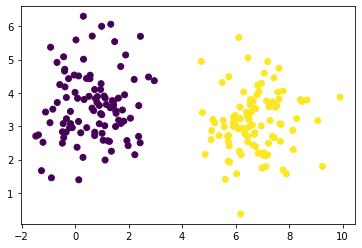

In [3]:
X,y = make_blobs(200,2,2,random_state=222)
y[y==0] = -1
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

## 1.1 原问题求解
<img align="left" src="https://cdn.jsdelivr.net/gh/QYHcrossover/blog-imgbed//blogimg/image-20211214122734566.png" alt="image-20211214122734566" style="zoom:50%;" />

In [4]:
class SVM:
    def __init__(self):
        self.W = None
        self.b = None

    def fit(self,X,y):
        #计算P
        P = np.identity(X.shape[-1]+1)
        P[0,0] = 0
        #计算q
        q = np.zeros(X.shape[-1]+1).reshape(-1,1)
        #计算G
        G = np.ones([X.shape[0],X.shape[-1]+1])
        G[:,1:] = X
        G = - y * G
        #计算h
        h = - np.ones(X.shape[0]).reshape(-1,1)
        #批量转换
        P,q,G,h = matrix(P),matrix(q),matrix(G),matrix(h)
        sol = solvers.qp(P,q,G,h)

        self.b = np.array(sol["x"])[0]
        self.W = np.array(sol["x"])[1:]
    
    def predict(self,X):
        predicts = X@self.W+self.b
        index1 = predicts<=0
        index2 = predicts>0
        predicts[index1] = -1
        predicts[index2] = 1
        return predicts.ravel()

In [5]:
svc = SVM()
svc.fit(X,y.reshape(-1,1))
print(svc.W,svc.b)

     pcost       dcost       gap    pres   dres
 0:  4.4602e-02  5.3916e+01  6e+02  2e+00  1e+03
 1:  3.5524e-01 -8.5786e+01  1e+02  3e-01  2e+02
 2:  5.8109e-01 -5.7832e+01  7e+01  2e-01  1e+02
 3:  7.3903e-01 -2.2704e+00  3e+00  6e-03  4e+00
 4:  6.5969e-01  5.0025e-01  2e-01  1e-04  7e-02
 5:  6.3867e-01  6.1736e-01  2e-02  1e-05  7e-03
 6:  6.3697e-01  6.3666e-01  3e-04  1e-07  8e-05
 7:  6.3694e-01  6.3694e-01  3e-06  1e-09  8e-07
 8:  6.3694e-01  6.3694e-01  3e-08  1e-11  8e-09
Optimal solution found.
[[1.12823756]
 [0.03108765]] [-4.47791928]


In [6]:
y_pred = svc.predict(X)
np.sum(y_pred.ravel() == y)/len(y)

1.0

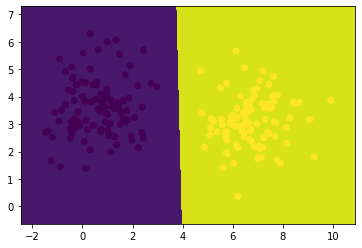

In [7]:
plot_clf(X,y,svc)

### 与PLA作对比

In [8]:
pla = PLA()
pla.fit(X,y.reshape(-1,1))

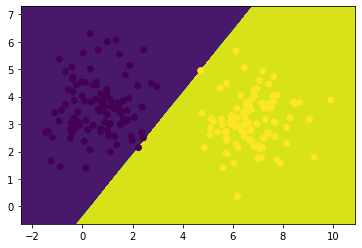

In [9]:
plot_clf(X,y,pla)

## 1.2 对偶问题求解
<img align="left" src="https://cdn.jsdelivr.net/gh/QYHcrossover/blog-imgbed//blogimg/image-20211214122841767.png" alt="image-20211214122841767" style="zoom:50%;" />

In [14]:
class SVM_dual:
    def fit(self,X,y):
        Xy = X * y.reshape(-1,1)
        P = Xy @ Xy.T
        q = -1*np.ones(X.shape[0]).reshape(-1,1)
        G = -1*np.identity(X.shape[0])
        h = np.zeros(X.shape[0]).reshape(-1,1)
        A = y.reshape(1,-1)
        b = np.zeros(1).reshape(-1,1)
        [P,q,G,h,A,b] = [matrix(i,i.shape,"d")for i in [P,q,G,h,A,b]]
        result = solvers.qp(P,q,G,h,A,b)
        self.A = np.array(result["x"])
        self.support_vector_index = np.where(self.A > 1e-4)[0]
        self.W = np.sum(self.A * Xy,axis=0).reshape(-1,1)
        self.b = y[self.support_vector_index[0]] - X[self.support_vector_index[0]].reshape(1,-1)@self.W
    
    def predict(self,X):
        predicts = X@self.W+self.b
        index1 = predicts<=0
        index2 = predicts>0
        predicts[index1] = -1
        predicts[index2] = 1
        return predicts.ravel()

In [15]:
svc = SVM_dual()
svc.fit(X,y)
print(svc.W,svc.b)

     pcost       dcost       gap    pres   dres
 0: -1.9167e+01 -3.4122e+01  6e+02  3e+01  2e+00
 1: -2.1114e+01 -7.5751e+00  1e+02  5e+00  3e-01
 2: -1.9766e+01 -3.9839e+00  7e+01  2e+00  2e-01
 3: -1.1958e+00 -7.5126e-01  3e+00  9e-02  6e-03
 4: -5.5672e-01 -6.5982e-01  2e-01  2e-03  1e-04
 5: -6.2303e-01 -6.3868e-01  2e-02  2e-04  1e-05
 6: -6.3672e-01 -6.3697e-01  3e-04  2e-06  1e-07
 7: -6.3694e-01 -6.3694e-01  3e-06  2e-08  1e-09
 8: -6.3694e-01 -6.3694e-01  3e-08  2e-10  1e-11
Optimal solution found.
[[1.12823756]
 [0.03108765]] [[-4.47791928]]


In [16]:
np.sum(svc.predict(X) == y)/len(y)

1.0

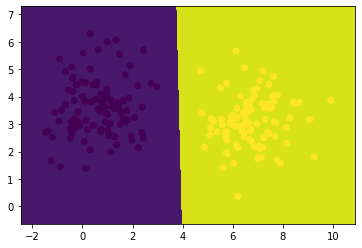

In [17]:
plot_clf(X,y,svc)

# 2. 线性不可分求解

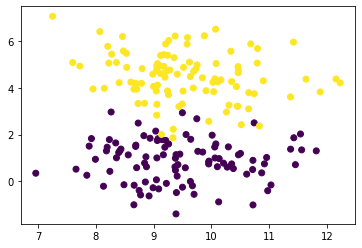

In [18]:
X,y = make_blobs(200,2,2,random_state=4)
y[y==0] = -1
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

## 2.1 原问题求解

<img align="left" src="https://cdn.jsdelivr.net/gh/QYHcrossover/blog-imgbed//blogimg/image-20211214122947479.png" alt="image-20211214122947479" style="zoom:50%;" />

In [19]:
class SVM_C:
    def __init__(self,C):
        self.C = C

    def fit(self,X,y):
        n_samples,n_features = X.shape
        
        P = np.zeros((n_features+n_samples+1,n_features+n_samples+1))
        P[1:n_features+1,1:n_features+1] = np.identity(n_features)
        
        q = np.zeros(n_features+n_samples+1)
        q[n_features+1:] = self.C
        q = q.reshape(-1,1)
        
        G = np.zeros((2*n_samples,n_features+n_samples+1))
        G[0:n_samples,0] = -y
        G[0:n_samples,1:n_features+1] = -y.reshape(-1,1)*X
        G[0:n_samples,n_features+1:] = -np.identity(n_samples)
        G[n_samples:,n_features+1:] = -np.identity(n_samples)
        
        h = np.zeros(2*n_samples)
        h[0:n_samples] = -1
        h = h.reshape(-1,1)
        
        [P,q,G,h] = [matrix(i) for i in [P,q,G,h]]
        sol = solvers.qp(P,q,G,h)

        self.b = np.array(sol["x"])[0]
        self.W = np.array(sol["x"])[1:n_features+1]
    
    def predict(self,X):
        predicts = X@self.W+self.b
        index1 = predicts<=0
        index2 = predicts>0
        predicts[index1] = -1
        predicts[index2] = 1
        return predicts.ravel()

In [20]:
svc = SVM_C(1)
svc.fit(X,y)

     pcost       dcost       gap    pres   dres
 0: -1.5470e+02  3.9616e+02  2e+03  4e+00  5e+01
 1:  1.5153e+02 -9.9047e+01  3e+02  5e-01  6e+00
 2:  3.9055e+01  1.5294e+00  5e+01  6e-02  7e-01
 3:  2.2173e+01  1.4404e+01  9e+00  9e-03  1e-01
 4:  1.9563e+01  1.6605e+01  3e+00  3e-03  3e-02
 5:  1.8806e+01  1.7550e+01  1e+00  7e-05  8e-04
 6:  1.8136e+01  1.8083e+01  5e-02  1e-06  1e-05
 7:  1.8106e+01  1.8103e+01  3e-03  5e-08  6e-07
 8:  1.8104e+01  1.8104e+01  3e-05  5e-10  6e-09
 9:  1.8104e+01  1.8104e+01  3e-07  5e-12  6e-11
Optimal solution found.


In [21]:
print(svc.W,svc.b)

[[0.12430787]
 [1.6713178 ]] [-5.52844039]


In [22]:
np.sum(svc.predict(X) == y)/len(y)

0.955

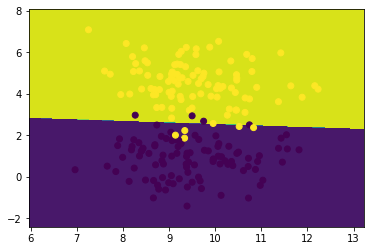

In [24]:
plot_clf(X,y,svc)

## 2.2 对偶问题求解
<img align="left" src="https://cdn.jsdelivr.net/gh/QYHcrossover/blog-imgbed//blogimg/image-20211214123043478.png" alt="image-20211214123043478" style="zoom:50%;" />

In [29]:
class SVM_C_dual:
    def __init__(self,C):
        self.C = C
    
    def fit(self,X,y):
        Xy = X * y.reshape(-1,1)
        P = Xy @ Xy.T
        q = -1*np.ones(X.shape[0]).reshape(-1,1)
        
        G = np.zeros((2*X.shape[0],X.shape[0]))
        G[0:X.shape[0]] = - np.identity(X.shape[0])
        G[X.shape[0]:] = np.identity(X.shape[0])
        h = np.zeros(2*X.shape[0])
        h[X.shape[0]:] = self.C
        h = h.reshape(-1,1)
        
        A = y.reshape(1,-1)
        b = np.zeros(1).reshape(-1,1)
        
        [P,q,G,h,A,b] = [matrix(i,i.shape,"d")for i in [P,q,G,h,A,b]]
        result = solvers.qp(P,q,G,h,A,b)
        self.A = np.array(result["x"])
        self.support_vector_index = np.where(self.A > 1e-4)[0]
        self.W = np.sum(self.A * Xy,axis=0).reshape(-1,1)
        self.b = y[self.support_vector_index[0]] - X[self.support_vector_index[0]].reshape(1,-1)@self.W
    
    def predict(self,X):
        predicts = X@self.W+self.b
        index1 = predicts<=0
        index2 = predicts>0
        predicts[index1] = -1
        predicts[index2] = 1
        return predicts.ravel()

In [30]:
svc = SVM_C_dual(1)
svc.fit(X,y)

     pcost       dcost       gap    pres   dres
 0: -4.4549e+01 -3.9690e+02  2e+03  2e+00  2e-13
 1: -2.7902e+01 -2.1973e+02  3e+02  3e-01  2e-13
 2: -1.7597e+01 -4.7177e+01  5e+01  4e-02  2e-13
 3: -1.6593e+01 -2.3516e+01  9e+00  6e-03  1e-13
 4: -1.7138e+01 -1.9942e+01  3e+00  2e-03  1e-13
 5: -1.7563e+01 -1.8815e+01  1e+00  4e-05  1e-13
 6: -1.8084e+01 -1.8137e+01  5e-02  7e-07  2e-13
 7: -1.8103e+01 -1.8106e+01  3e-03  3e-08  1e-13
 8: -1.8104e+01 -1.8104e+01  3e-05  3e-10  1e-13
 9: -1.8104e+01 -1.8104e+01  3e-07  3e-12  1e-13
Optimal solution found.


In [31]:
np.sum(svc.predict(X) == y) / len(y)

0.955

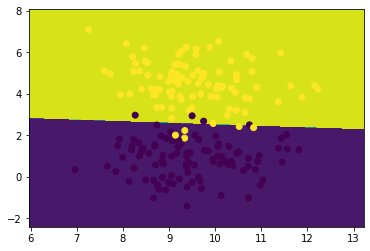

In [32]:
plot_clf(X,y,svc)

# 3. 非线性支持向量机

<img align="left" src="https://cdn.jsdelivr.net/gh/QYHcrossover/blog-imgbed//blogimg/image-20211214163219911.png" alt="image-20211214163219911" style="zoom:50%;" />

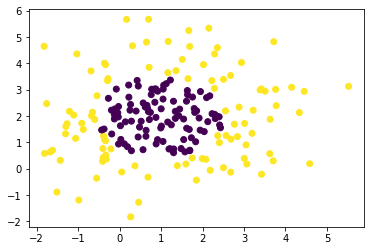

In [44]:
from sklearn.datasets import make_gaussian_quantiles
X, y = make_gaussian_quantiles(n_samples=200, n_features=2, n_classes=2, mean=[1,2],cov=2,random_state=222)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

In [46]:
y[y==0] = -1

In [81]:
class SVM_Gaussian_Kernel:
    def __init__(self,sigma=1,C=1):
        self.sigma = sigma
        self.C = C
    
    def _gaussian(self,x,z):
        return np.exp(-0.5*np.sum((x-z)**2)/(self.sigma**2))
    
    def fit(self,X,y):
        mat = np.zeros((X.shape[0],X.shape[0]))
        for i in range(X.shape[0]):
            for j in range(i,X.shape[0]):
                result = self._gaussian(X[i],X[j])
                mat[i,j] = result
                mat[j,i] = result
        P = mat * (y.reshape(-1,1) @ y.reshape(1,-1))
        q = -1*np.ones(X.shape[0]).reshape(-1,1)
        
        G = np.zeros((2*X.shape[0],X.shape[0]))
        G[0:X.shape[0]] = - np.identity(X.shape[0])
        G[X.shape[0]:] = np.identity(X.shape[0])
        h = np.zeros(2*X.shape[0])
        h[X.shape[0]:] = self.C
        h = h.reshape(-1,1)
        
        A = y.reshape(1,-1)
        b = np.zeros(1).reshape(-1,1)
        
        [P,q,G,h,A,b] = [matrix(i,i.shape,"d")for i in [P,q,G,h,A,b]]
        result = solvers.qp(P,q,G,h,A,b)
        self.A = np.array(result["x"])
        support_vector_index = np.where(self.A > 1e-4)[0]
        self.support_vectors = X[support_vector_index]
        self.support_vector_as = self.A[support_vector_index,0]
        self.support_vector_ys = y[support_vector_index]
        for i,a in enumerate(self.A):
            if a>0 and a<self.C:
                self.b = y[i] - np.sum(self.A.ravel()*y*mat[i])
                break
    
    def predict(self,X):
        preds = []
        for x in tqdm(X):
            Ks = [self._gaussian(x,support_vector) for support_vector in self.support_vectors]
            pred = np.sum(self.support_vector_as * self.support_vector_ys * Ks) + self.b
            pred = 1 if pred >=0 else -1
            preds.append(pred)
        return np.array(preds)

In [84]:
svc = SVM_Gaussian_Kernel()
svc.fit(X,y)

     pcost       dcost       gap    pres   dres
 0: -3.8165e+01 -3.2524e+02  1e+03  2e+00  9e-16
 1: -2.5527e+01 -1.7422e+02  2e+02  1e-01  7e-16
 2: -3.0000e+01 -5.4289e+01  3e+01  2e-02  9e-16
 3: -3.6650e+01 -4.4526e+01  8e+00  4e-03  8e-16
 4: -3.9036e+01 -4.1210e+01  2e+00  9e-04  7e-16
 5: -3.9818e+01 -4.0253e+01  4e-01  4e-05  8e-16
 6: -3.9996e+01 -4.0037e+01  4e-02  2e-06  9e-16
 7: -4.0015e+01 -4.0015e+01  7e-04  2e-08  8e-16
 8: -4.0015e+01 -4.0015e+01  7e-06  2e-10  9e-16
Optimal solution found.


In [85]:
np.sum(svc.predict(X) == y)/ len(y)

100%|███████████| 200/200 [00:00<00:00, 1840.01it/s]


0.95

100%|█████| 222300/222300 [02:00<00:00, 1842.59it/s]


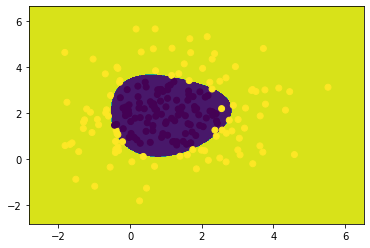

In [87]:
plot_clf(X,y,svc)